In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
import torch
import torchaudio
import seaborn as sns 
import sklearn 
from IPython.display import Audio, display
import torchaudio.functional as F
import torchaudio.transforms as T
import warnings
warnings.filterwarnings('ignore')
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

In [2]:
# load dataset from input directory
df = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


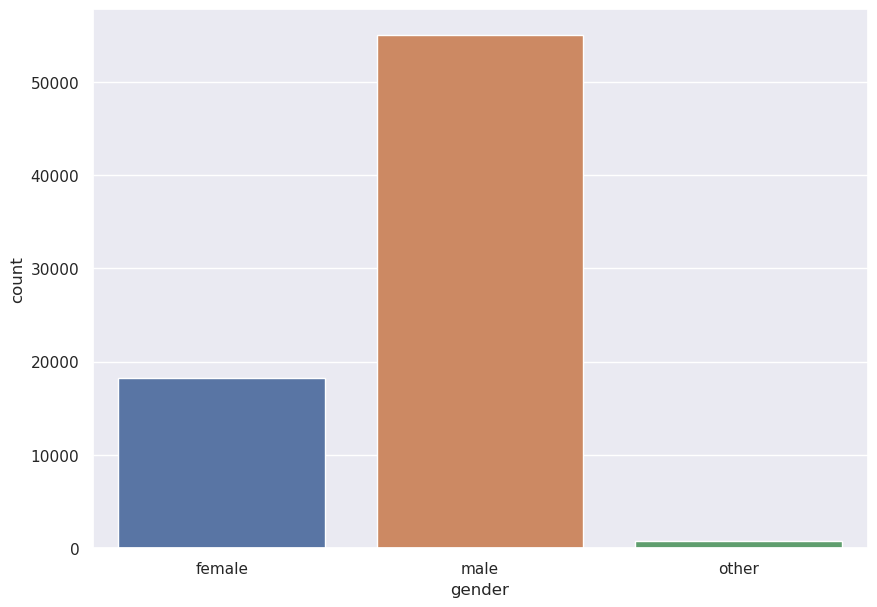

In [3]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.countplot(x="gender", 
        data=df[df['gender'].notna()])

plt.show()

In [4]:
#Clean up dataframe
def clean(df):
    df = df[['filename','gender']]
    data = df[df['gender'].notna()]
    data.reset_index(inplace=True, drop=True)
    data.head()
    return data

df = clean(df)
print(len(df))
df.head()

74059


,filename,gender
0,cv-valid-train/sample-000005.mp3,female
1,cv-valid-train/sample-000008.mp3,male
2,cv-valid-train/sample-000013.mp3,female
3,cv-valid-train/sample-000014.mp3,male
4,cv-valid-train/sample-000019.mp3,male


In [5]:
#Shorten the dataset to limit time needed to train model
df = df.drop(df[:60000].index)
print(df.gender.value_counts())
print(df['gender'].unique())
df.head()

male      10481
female     3437
other       141
Name: gender, dtype: int64
['female' 'male' 'other']


,filename,gender
60000,cv-valid-train/sample-158689.mp3,female
60001,cv-valid-train/sample-158693.mp3,male
60002,cv-valid-train/sample-158694.mp3,male
60003,cv-valid-train/sample-158698.mp3,male
60004,cv-valid-train/sample-158700.mp3,male


In [6]:
#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]


def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

tensor([ 0.0000e+00,  3.5230e-15, -2.7470e-15,  ...,  3.3758e-08,
         2.2139e-08, -2.3758e-08])
Sample Rate: 48000
Shape: (1, 279936)
Dtype: torch.float32
 - Max:      0.065
 - Min:     -0.058
 - Mean:    -0.000
 - Std Dev:  0.010

tensor([[ 0.0000e+00,  3.5230e-15, -2.7470e-15,  ...,  3.3758e-08,
          2.2139e-08, -2.3758e-08]])



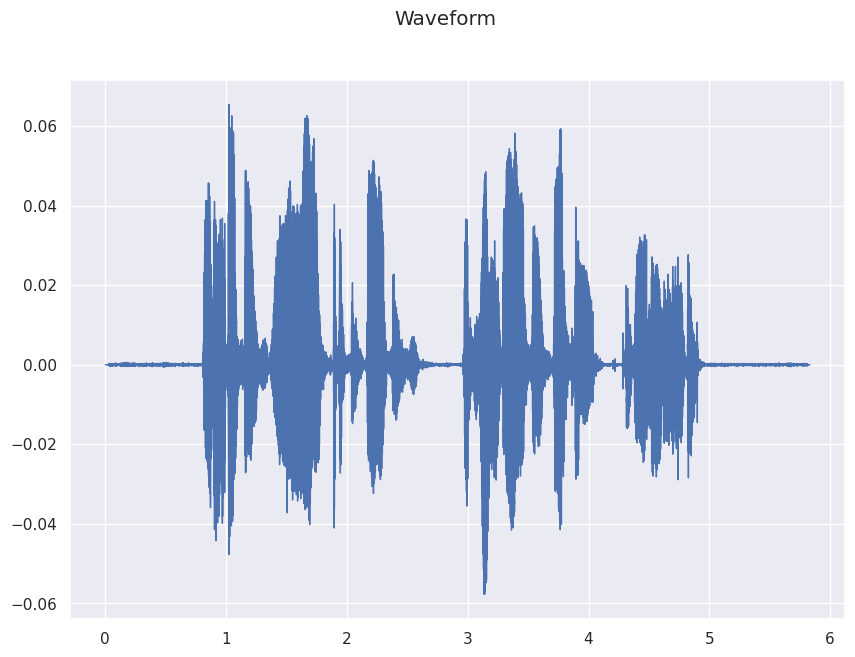

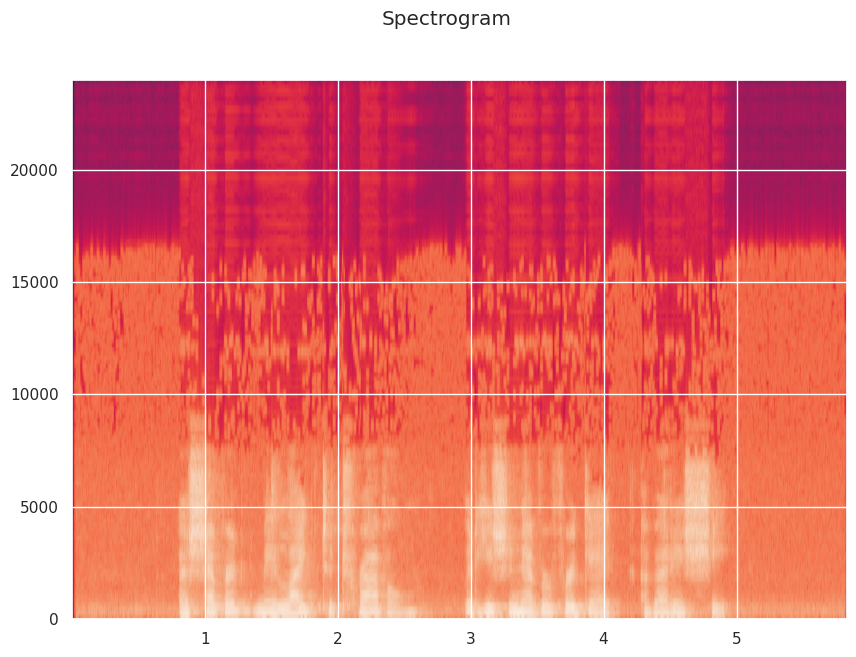

In [7]:
#Load mp3 audio file into waveform
waveform, sample_rate = torchaudio.load("/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3")
print(waveform[0])

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)


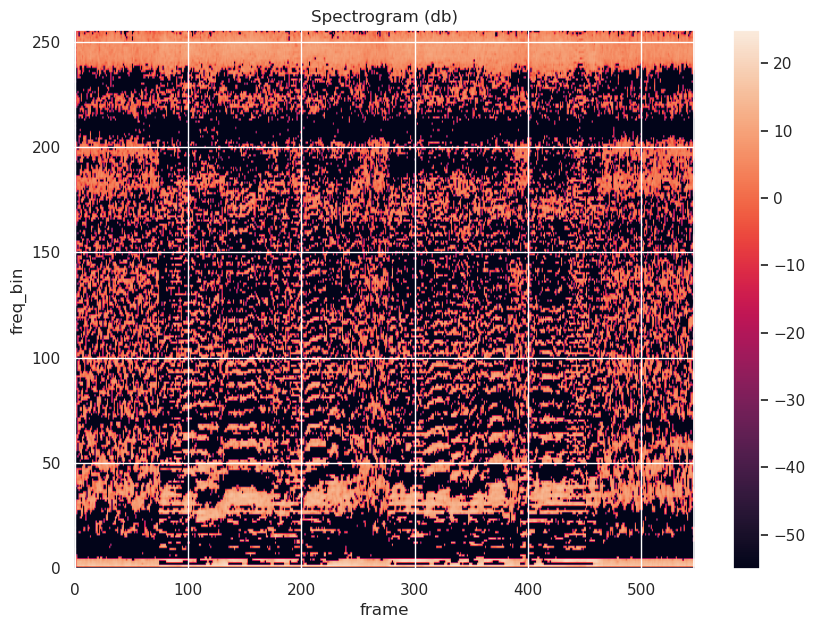

In [8]:
#Audio feature extraction

def to_mfcc(waveform, n_fft = 2048, win_length = None, hop_length = 512, n_mels = 256, n_mfcc = 256):
    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
        )

    return mfcc_transform(waveform)

mfcc = to_mfcc(waveform)
#print(mfcc)
plot_spectrogram(mfcc[0])

In [9]:
#Feature extraction
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)

#     spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
#     spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
#     spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

#     features.append(spectral_centroid)
#     features.append(spectral_bandwidth)
#     features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(df.iloc[0]['filename'])
print("features: ", features)

features:  [-438.64035, 58.30499, -7.3278446, 7.797467, 12.89807, -2.2057111, -2.9186597, -4.3557253, -3.1496694, -4.5876484, -11.839517, -6.137477, -1.8041581, -5.229132, -3.0734558, -4.2230306, -3.8100104, 1.49115, -1.9616215, -2.3178797]


In [10]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 70000
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['gender'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20","gender"])

df_features = create_df_features(df)
df_features.head()

69999/14058

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,gender
0,-438.640350,58.304989,-7.327845,7.797467,12.898070,-2.205711,-2.918660,-4.355725,-3.149669,-4.587648,...,-6.137477,-1.804158,-5.229132,-3.073456,-4.223031,-3.810010,1.491150,-1.961622,-2.317880,female
1,-388.137512,133.419312,-3.197466,34.005650,31.341309,1.578951,-5.407432,5.732386,3.806240,-7.731826,...,1.861527,-4.482795,-3.351508,-0.867037,-0.359519,-3.145406,0.895699,-1.235209,-5.451189,male
2,-359.037964,170.363434,0.304372,20.404892,32.291763,4.426670,-12.116422,3.010976,5.397043,-11.408336,...,3.175894,-4.344876,-6.070332,-0.807524,-0.293959,-3.558247,-0.032471,-1.337030,-4.886075,male
3,-375.007996,101.228539,-2.957791,12.704235,9.466905,14.389581,11.849578,-4.777654,-3.511195,-1.350946,...,-4.908238,0.643793,-1.157274,-2.068393,-2.372293,-6.227129,-4.239280,-2.596651,-0.861714,male
4,-372.636505,125.144562,-27.053240,19.921255,7.709876,-4.658391,-0.010077,-8.259809,-8.403128,4.037549,...,-5.612735,-0.383341,-7.973960,-3.202068,-7.265501,-8.037347,-4.527579,-1.378681,-3.272385,male


In [11]:
np.save("df_features", df_features)
df_features['gender'].unique()

array(['female', 'male', 'other'], dtype=object)

In [12]:
def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 0:-1], dtype = float))
    # with data.iloc[:, 0:-1] we don't consider the label column
        
    return scaled_data, scaler

x, scaler = scale_features(df_features)
print("Before scaling:", df_features.iloc[0].values[:-1])
print("\nAfter scaling:", x[0])

Before scaling: [-438.64035 58.30499 -7.3278446 7.797467 12.89807 -2.2057111 -2.9186597
 -4.3557253 -3.1496694 -4.5876484 -11.839517 -6.137477 -1.8041581
 -5.229132 -3.0734558 -4.2230306 -3.8100104 1.49115 -1.9616215 -2.3178797]

After scaling: [ 0.04589355 -2.29362553 -0.19581778 -0.99375832  0.3223153  -0.67952362
 -0.0683722  -0.20381262  0.05455479  0.11549487 -1.24959448 -0.33033385
  0.05351891  0.02474215 -0.03353992 -0.28443189 -0.07798458  0.84660306
 -0.02599192  0.47532351]


In [13]:
def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(df_features)
classes = encoder.classes_
print("Before encoding:", df_features.iloc[0].values[-1])
print("\nAfter encoding:", y[0:5])
print("\nClasses:", classes)

Before encoding: female

After encoding: [0 1 1 1 1]

Classes: ['female' 'male' 'other']


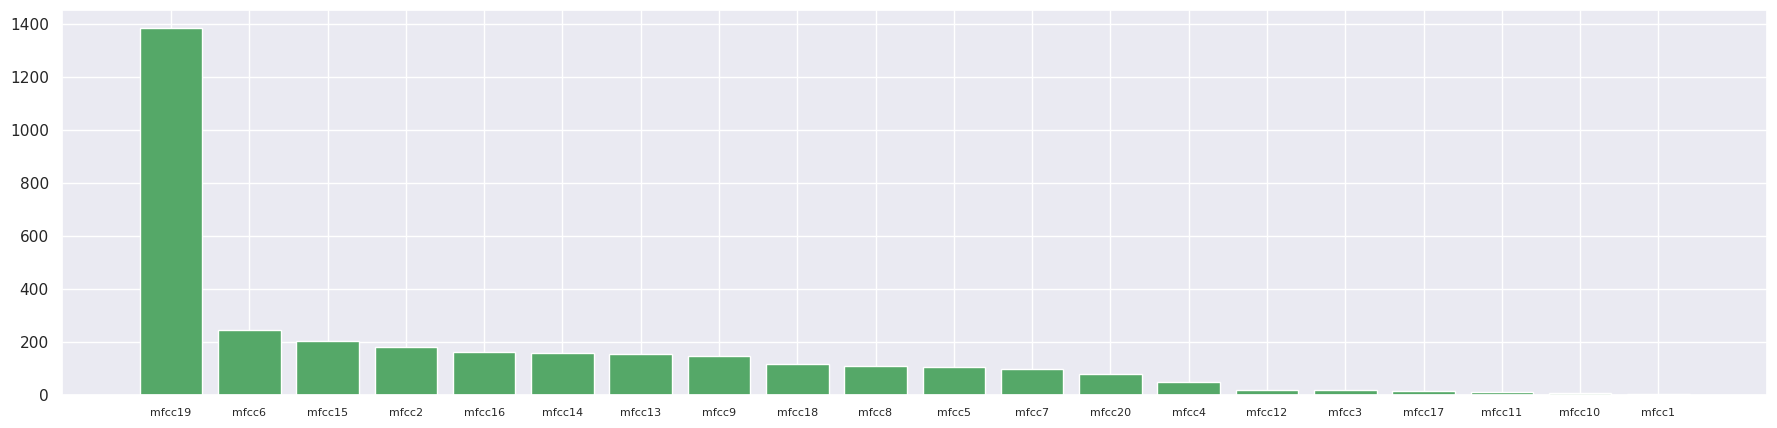

In [14]:
#Feature selection

n_features = 20

f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)
scores = f_selector.scores_

indices = np.argsort(scores)[::-1]

features = []
for i in range(n_features):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(22, 5))
plt.bar(features, scores[indices[range(n_features)]], color='g')
plt.xticks(fontsize=8)
plt.show()

In [15]:
#Model Selection

classifiers_and_params = [
    (SVC(), {'C': [200, 150, 100], 'gamma': ['auto', 'scale']}),
#      (RandomForestClassifier(), {'n_estimators': [100, 150, 200]}),
    (MLPClassifier(), {'hidden_layer_sizes': [100, 150, 200]})
]

for tup in classifiers_and_params:
    print("{}".format(tup[0].__class__.__name__))
    
    # main CV process
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_counter = 0

    results = list()
    for train_idx, test_idx in outer_cv.split(X_new):
        fold_counter += 1
        
        # split data in training and test sets
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # the CV process used for the Grid Search
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

        # define and run the Grid Search CV process
        gs = GridSearchCV(tup[0], tup[1], scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        # get the best model, re-fit on the whole training set
        best_model = res.best_estimator_

        # evaluation on the test set
        pred = best_model.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        results.append(score)
        
        print("\tFold {}, Best Params {} with F1 Score {:.3f}, F1 Score on Test data {:.3f}"
              .format(fold_counter, res.best_params_, res.best_score_, score))

    print('\tAverage F1 Score on Test Set: {:.3f}\n'.format(np.mean(results)))

SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.703, F1 Score on Test data 0.765
	Fold 2, Best Params {'C': 150, 'gamma': 'scale'} with F1 Score 0.737, F1 Score on Test data 0.766
	Fold 3, Best Params {'C': 150, 'gamma': 'auto'} with F1 Score 0.739, F1 Score on Test data 0.801
	Average F1 Score on Test Set: 0.777

MLPClassifier
	Fold 1, Best Params {'hidden_layer_sizes': 150} with F1 Score 0.669, F1 Score on Test data 0.704
	Fold 2, Best Params {'hidden_layer_sizes': 150} with F1 Score 0.658, F1 Score on Test data 0.652
	Fold 3, Best Params {'hidden_layer_sizes': 150} with F1 Score 0.688, F1 Score on Test data 0.727
	Average F1 Score on Test Set: 0.694



In [16]:
def my_plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix (not normalized)"
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title)

    thresh = cm.max() / 2.
    fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

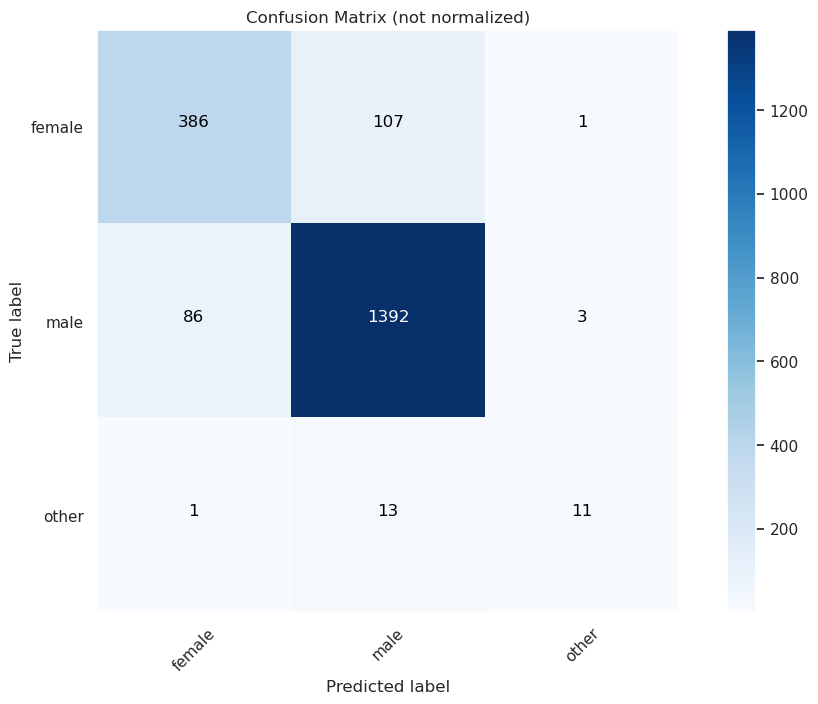

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

model = SVC(C=100, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
my_plot_confusion_matrix(cm, classes=classes)

plt.grid(False)
plt.show()

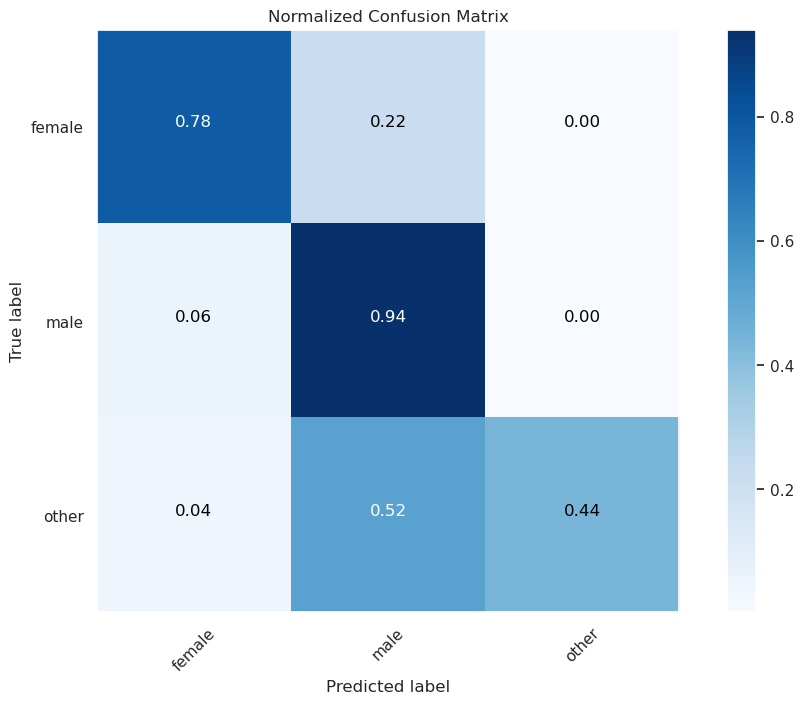

In [18]:
# Plot normalized confusion matrix
plt.figure()
my_plot_confusion_matrix(cm, classes=classes, normalize=True)

plt.grid(False)
plt.show()

In [19]:
import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)

['finalized_model.sav']

In [20]:
#Create a Convolutional Neural Network

import torch.nn as nn
import torch.optim as optim

#Modify layers later to get better results
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#Define loss function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
#Train model

trainloader = []
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Done!')

Done!


In [22]:
#Save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)